In [1]:
# =============================================================================
# 1. Импорты и базовые настройки
# =============================================================================
import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Библиотеки для обработки текста
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Библиотеки для работы с изображениями
from PIL import Image
import torchvision.transforms as T
from torchvision.models import resnet50, ResNet50_Weights

# Модели из transformers
from transformers import BertTokenizer, BertModel

# PyTorch и сопутствующие модули
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Метрики и разделение данных
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

# Обёртка PyTorch-модели через skorch
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, EpochScoring

# Дополнительно для альтернативного поиска (CLIP)
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Deвайс\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Deвайс\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Deвайс\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Устанавливаем фиксированное семя для воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Определяем устройство вычислений (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Используем устройство:", device)

Используем устройство: cuda


In [3]:
# =============================================================================
# 2. Загрузка данных
# =============================================================================
# Задайте базовый путь к данным (отредактируйте при необходимости)
base_dir = "C:/Users/Deвайс/ML/to_upload"

# Пути к файлам и папкам
train_csv     = os.path.join(base_dir, "train_dataset.csv")
expert_csv    = os.path.join(base_dir, "ExpertAnnotations.tsv")
crowd_csv     = os.path.join(base_dir, "CrowdAnnotations.tsv")
test_csv      = os.path.join(base_dir, "test_queries.csv")
train_imgs_dir= os.path.join(base_dir, "train_images")
test_imgs_dir = os.path.join(base_dir, "test_images")

In [4]:
# Загружаем обучающий датасет (ожидается наличие столбцов: image, query_id, query_text)
df_train = pd.read_csv(train_csv)
print("Размер обучающего датасета:", df_train.shape)

# Загружаем экспертские оценки (без заголовков, задаём собственные имена столбцов)
df_expert = pd.read_csv(expert_csv, sep='\t', header=None, 
                        names=['image', 'query_id', 'score1', 'score2', 'score3'])
print("Размер экспертского датасета:", df_expert.shape)

# (При необходимости можно загрузить и краудсорсинговые оценки)
df_crowd = pd.read_csv(crowd_csv, sep='\t', header=None,
                       names=['image', 'query_id', 'scr', 'yes', 'no'])
print("Размер краудсорсингового датасета:", df_crowd.shape)

Размер обучающего датасета: (5822, 3)
Размер экспертского датасета: (5822, 5)
Размер краудсорсингового датасета: (47830, 5)


In [5]:
# =============================================================================
# 3. Предобработка текстов и фильтрация записей
# =============================================================================
def normalize_text(txt):
    """Переводит в нижний регистр, удаляет всё, кроме букв и пробелов, нормализует пробелы."""
    txt = txt.lower()
    txt = re.sub(r'[^a-z\s]', ' ', txt)
    txt = re.sub(r'\s+', ' ', txt).strip()
    return txt

In [6]:
# Инициализируем стоп-слова и лемматизатор
stop_list = set(stopwords.words('english'))
lemmatizer_obj = WordNetLemmatizer()

In [7]:
def process_query(txt):
    """Обрабатывает текст: нормализует, токенизирует, удаляет стоп-слова и лемматизирует."""
    txt = normalize_text(txt)
    tokens = word_tokenize(txt)
    tokens = [lemmatizer_obj.lemmatize(word) for word in tokens if word not in stop_list]
    return " ".join(tokens)

In [8]:
# Применяем обработку к текстовым описаниям
df_train['proc_text'] = df_train['query_text'].apply(process_query)

In [9]:
# Фильтрация по ключевым словам, связанным с несовершеннолетними
minors_keywords = ['child', 'boy', 'girl', 'toddler', 'baby', 'kid']
def contains_minors(txt):
    words = txt.split()
    return any(w in words for w in minors_keywords)

df_train['has_minors'] = df_train['proc_text'].apply(contains_minors)
print("Количество записей с упоминанием детей:", df_train['has_minors'].sum())

# Исключаем записи с детьми (для соблюдения юридических ограничений)
df_train = df_train[~df_train['has_minors']].copy()
print("Размер обучающего датасета после фильтрации:", df_train.shape)

Количество записей с упоминанием детей: 1557
Размер обучающего датасета после фильтрации: (4265, 5)


In [10]:
# =============================================================================
# 4. Объединение оценок
# =============================================================================
# Вычисляем среднее экспертских оценок и нормируем их (из шкалы 1–4 в [0,1])
df_expert['avg_score'] = df_expert[['score1', 'score2', 'score3']].mean(axis=1)
df_expert['norm_score'] = (df_expert['avg_score'] - 1) / 3.0

# Объединяем обучающий датасет с экспертскими оценками по полям "image" и "query_id"
df_merged = pd.merge(df_train, df_expert[['image', 'query_id', 'norm_score']],
                     on=['image', 'query_id'], how='inner')
print("Размер объединённого датасета:", df_merged.shape)

# Задаём целевую переменную
df_merged['target'] = df_merged['norm_score']

Размер объединённого датасета: (4265, 6)


In [11]:
# =============================================================================
# 5. Векторизация текстов и изображений (для обучения)
# =============================================================================

# 5.1. Текстовая векторизация с помощью BERT
bert_tok = BertTokenizer.from_pretrained('bert-base-uncased')
bert_mod = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_mod.eval()

def get_text_feat(txt):
    inputs = bert_tok(txt, return_tensors="pt", truncation=True, padding=True, max_length=128)
    # Перемещаем тензоры на устройство (CPU/GPU)
    for key in inputs:
        inputs[key] = inputs[key].to(device)
    with torch.no_grad():
        outputs = bert_mod(**inputs)
    cls_emb = outputs.last_hidden_state[:, 0, :]  # размерность 768
    return cls_emb.squeeze(0).cpu().numpy()

# 5.2. Векторизация изображений с помощью ResNet50
resnet_weights = ResNet50_Weights.IMAGENET1K_V2
resnet_mod = resnet50(weights=resnet_weights)
# Убираем последний слой (fully-connected) для получения эмбеддингов размером 2048
resnet_mod = nn.Sequential(*list(resnet_mod.children())[:-1]).to(device)
resnet_mod.eval()

img_trans = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

def get_image_feat(img_path):
    try:
        img = Image.open(img_path).convert("RGB")
    except Exception as e:
        print(f"Ошибка открытия {img_path}: {e}")
        return None
    img_tensor = img_trans(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = resnet_mod(img_tensor)
    feat = feat.view(feat.size(0), -1)  # размерность 2048 для ResNet50
    return feat.squeeze(0).cpu().numpy()

In [12]:
# =============================================================================
# 6. Вычисление эмбеддингов обучающих примеров и сохранение их на диск
# =============================================================================

# Пути для сохранения эмбеддингов, меток и групп
emb_file    = os.path.join(base_dir, "train_embeddings.npy")
labels_file = os.path.join(base_dir, "train_labels.npy")
groups_file = os.path.join(base_dir, "train_groups.npy")

if os.path.exists(emb_file) and os.path.exists(labels_file) and os.path.exists(groups_file):
    print("Загружаем сохранённые эмбеддинги обучающих данных...")
    X_all = np.load(emb_file)
    y_all = np.load(labels_file)
    groups_all = np.load(groups_file)
    print("Размер матрицы признаков:", X_all.shape)
else:
    print("Вычисляем эмбеддинги обучающих данных...")
    X_list, y_list, groups_list = [], [], []
    # Для каждого примера объединяем эмбеддинг изображения (2048) и текста (768) → 2816
    for idx, row in tqdm(df_merged.iterrows(), total=len(df_merged), desc="Обработка обучающих примеров"):
        img_path = os.path.join(train_imgs_dir, row["image"])
        img_feat = get_image_feat(img_path)
        if img_feat is None:
            continue
        txt_feat = get_text_feat(row["proc_text"])
        combined = np.concatenate([img_feat, txt_feat])
        X_list.append(combined)
        y_list.append(row["target"])
        groups_list.append(row["image"])
    X_all = np.array(X_list)
    y_all = np.array(y_list).reshape(-1, 1)
    groups_all = np.array(groups_list)
    print("Размер матрицы признаков:", X_all.shape)
    np.save(emb_file, X_all)
    np.save(labels_file, y_all)
    np.save(groups_file, groups_all)

Загружаем сохранённые эмбеддинги обучающих данных...
Размер матрицы признаков: (4265, 2816)


In [13]:
# =============================================================================
# 7. Разбиение на обучающую и валидационную выборки
# =============================================================================
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=SEED)
tr_idx, val_idx = next(gss.split(X_all, y_all, groups=groups_all))
X_train, X_val = X_all[tr_idx], X_all[val_idx]
y_train, y_val = y_all[tr_idx], y_all[val_idx]
print("Обучающая выборка:", X_train.shape, y_train.shape)
print("Валидационная выборка:", X_val.shape, y_val.shape)

# Приводим типы данных к np.float32
X_train = X_train.astype(np.float32)
X_val   = X_val.astype(np.float32)
y_train = y_train.astype(np.float32)
y_val   = y_val.astype(np.float32)

Обучающая выборка: (3426, 2816) (3426, 1)
Валидационная выборка: (839, 2816) (839, 1)


In [14]:
# =============================================================================
# 8. Определение регрессионной модели и обучение (skorch)
# =============================================================================
class RegressorNet(nn.Module):
    def __init__(self, in_dim=2816):
        super(RegressorNet, self).__init__()
        self.fc1 = nn.Linear(in_dim, 1024)
        self.relu1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.2)
        
        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.drop2 = nn.Dropout(0.2)
        
        self.fc3 = nn.Linear(512, 256)
        self.relu3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.2)
        
        self.fc4 = nn.Linear(256, 64)
        self.relu4 = nn.ReLU()
        self.drop4 = nn.Dropout(0.2)
        
        self.out = nn.Linear(64, 1)
        
    def forward(self, x):
        x = self.drop1(self.relu1(self.fc1(x)))
        x = self.drop2(self.relu2(self.fc2(x)))
        x = self.drop3(self.relu3(self.fc3(x)))
        x = self.drop4(self.relu4(self.fc4(x)))
        x = self.out(x)
        return x.view(-1)

def compute_rmse(net, X, y):
    preds = net.predict(X)
    return sqrt(mean_squared_error(y, preds))

regressor = NeuralNetRegressor(
    module=RegressorNet,
    module__in_dim=2816,  # 2048 (изображение) + 768 (текст) = 2816
    max_epochs=100,
    lr=0.001,
    batch_size=32,
    optimizer=optim.Adam,
    criterion=nn.MSELoss,
    callbacks=[
        EarlyStopping(patience=10),
        EpochScoring(scoring=compute_rmse, lower_is_better=True, on_train=True, name='train_rmse')
    ],
    device=device,
    verbose=1
)

In [15]:
print("Начало обучения регрессионной модели...")
regressor.fit(X_train, y_train.ravel())
val_rmse = compute_rmse(regressor, X_val, y_val)
print("Validation RMSE:", val_rmse)

Начало обучения регрессионной модели...
  epoch    train_loss    train_rmse    valid_loss     dur
-------  ------------  ------------  ------------  ------
      1        0.0750        0.2738        0.0705  0.3824
      2        0.0631        0.2511        0.0599  0.2677
      3        0.0555        0.2355        0.0584  0.2653
      4        0.0461        0.2148        0.0573  0.2695
      5        0.0436        0.2088        0.0601  0.2694
      6        0.0403        0.2008        0.0633  0.2630
      7        0.0388        0.1969        0.0664  0.2687
      8        0.0365        0.1912        0.0651  0.2613
      9        0.0385        0.1962        0.0730  0.2627
     10        0.0335        0.1831        0.0633  0.2625
     11        0.0336        0.1832        0.0609  0.2604
     12        0.0284        0.1686        0.0646  0.2766
     13        0.0280        0.1673        0.0677  0.2562
Stopping since valid_loss has not improved in the last 10 epochs.
Validation RMSE: 0.24445

Загружаем эмбеддинги тестовых изображений...
Количество тестовых запросов: 501

Предсказания для запроса: 'A group of girls who are gothically dressed standing together'
Минимальное значение: 0.03142035 Максимальное: 0.3290345 Среднее: 0.09409251
Запрос: A group of girls who are gothically dressed standing together
Лучшее изображение: 3287969199_08e775d896.jpg
Оценка: 0.3290



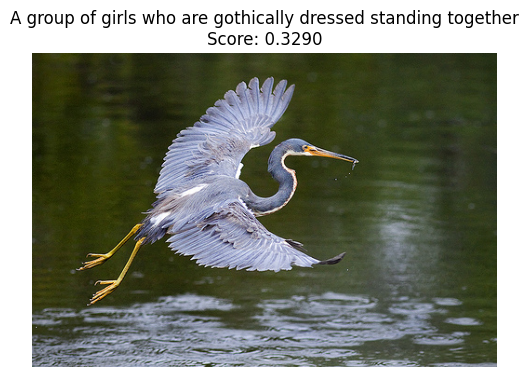


Предсказания для запроса: 'A woman and a young girl riding a sled down a snowy hill while standing .'
Минимальное значение: 0.009472877 Максимальное: 0.22849199 Среднее: 0.072203256
Запрос: A woman and a young girl riding a sled down a snowy hill while standing .
Лучшее изображение: 3287969199_08e775d896.jpg
Оценка: 0.2285



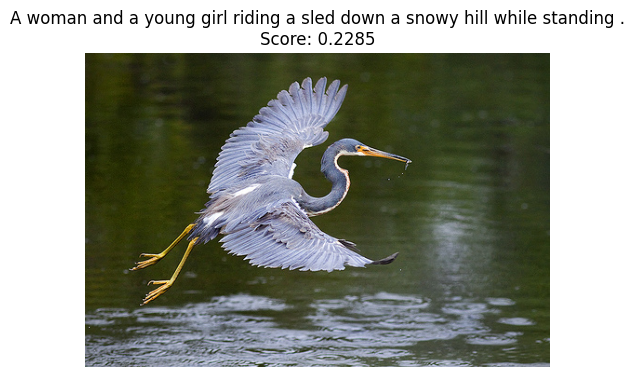


Предсказания для запроса: 'The dog is running .'
Минимальное значение: -0.008917764 Максимальное: 0.37826264 Среднее: 0.08063474
Запрос: The dog is running .
Лучшее изображение: 3287969199_08e775d896.jpg
Оценка: 0.3783



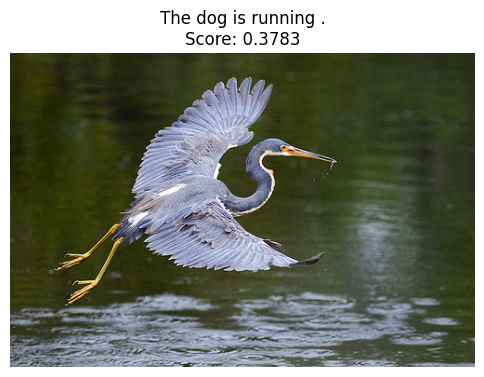


Предсказания для запроса: 'The woman with a henna tattoo holds a piece of paper in her left hand .'
Минимальное значение: 0.02109588 Максимальное: 0.30808574 Среднее: 0.06901526
Запрос: The woman with a henna tattoo holds a piece of paper in her left hand .
Лучшее изображение: 3287969199_08e775d896.jpg
Оценка: 0.3081



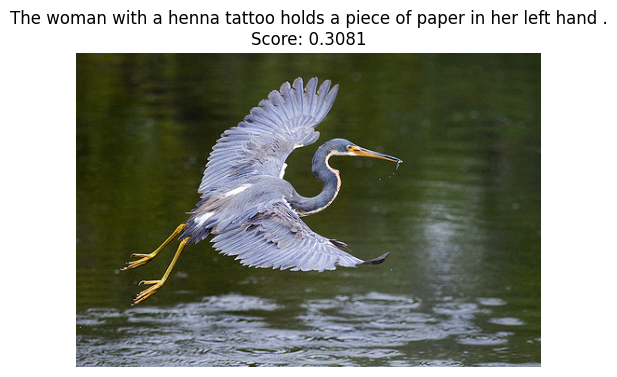


Предсказания для запроса: 'A young girl in blue hat and coat is riding a tricycle .'
Минимальное значение: 0.026238315 Максимальное: 0.2874288 Среднее: 0.07199525
Запрос: A young girl in blue hat and coat is riding a tricycle .
Лучшее изображение: 3287969199_08e775d896.jpg
Оценка: 0.2874



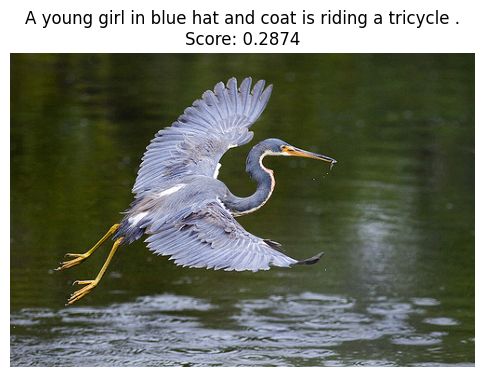


Предсказания для запроса: 'Two black dogs fighting over an orange toy .'
Минимальное значение: -0.02734539 Максимальное: 0.46522355 Среднее: 0.1176472
Запрос: Two black dogs fighting over an orange toy .
Лучшее изображение: 3287969199_08e775d896.jpg
Оценка: 0.4652



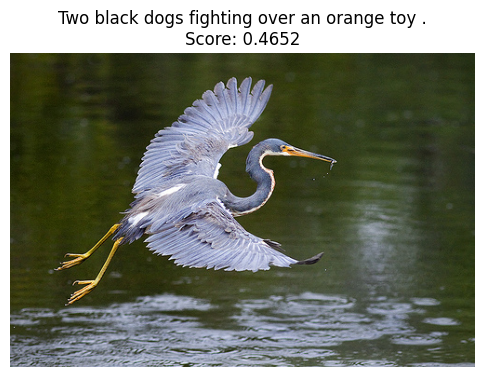


Предсказания для запроса: 'A dog jumping for a tennis ball near an ocean'
Минимальное значение: -0.020380422 Максимальное: 0.45537168 Среднее: 0.10254684
Запрос: A dog jumping for a tennis ball near an ocean
Лучшее изображение: 3287969199_08e775d896.jpg
Оценка: 0.4554



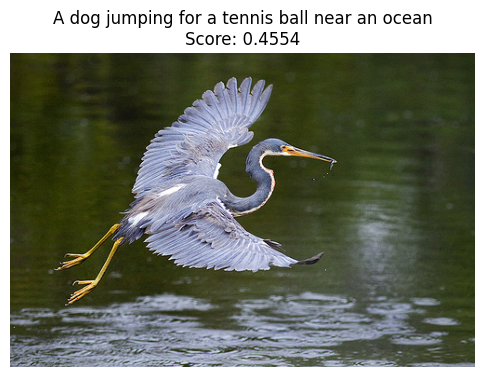


Предсказания для запроса: 'A little boy is flying a kite high up in the air .'
Минимальное значение: 0.031916678 Максимальное: 0.31012613 Среднее: 0.087089434
Запрос: A little boy is flying a kite high up in the air .
Лучшее изображение: 3287969199_08e775d896.jpg
Оценка: 0.3101



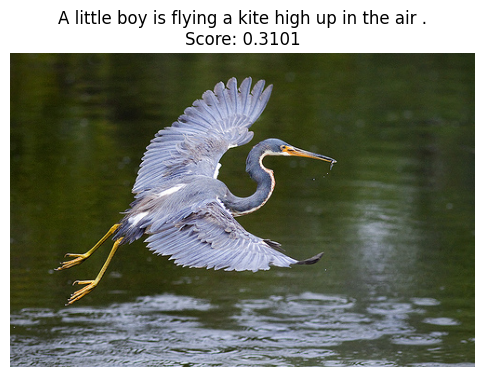


Предсказания для запроса: 'A group of people in a large yard toss a disc .'
Минимальное значение: 0.019055523 Максимальное: 0.3600021 Среднее: 0.08900333
Запрос: A group of people in a large yard toss a disc .
Лучшее изображение: 3287969199_08e775d896.jpg
Оценка: 0.3600



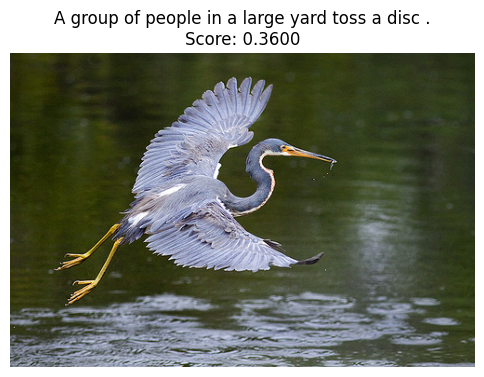


Предсказания для запроса: 'A girl in a purple shirt feeding ducks'
Минимальное значение: -0.011932626 Максимальное: 0.26883605 Среднее: 0.065979525
Запрос: A girl in a purple shirt feeding ducks
Лучшее изображение: 3287969199_08e775d896.jpg
Оценка: 0.2688



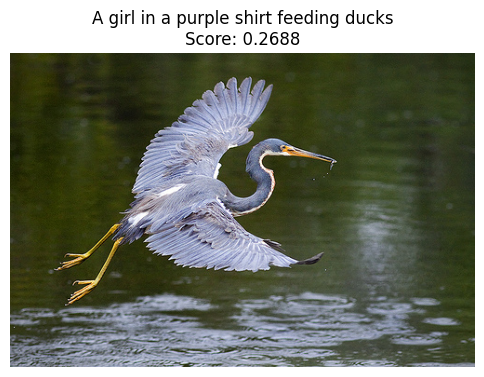

In [18]:
# =============================================================================
# 9. Тестирование модели с использованием регрессора
# =============================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Указываем папку с тестовыми изображениями и файл для сохранения эмбеддингов
test_imgs_dir = os.path.join(base_dir, "test_images")
test_emb_file = os.path.join(base_dir, "test_embeddings.npy")

# Фильтруем файлы по допустимым расширениям
valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
test_files = sorted([f for f in os.listdir(test_imgs_dir) if f.lower().endswith(valid_extensions)])

# Получение эмбеддингов тестовых изображений (если они уже сохранены — загружаем, иначе вычисляем)
if os.path.exists(test_emb_file):
    print("Загружаем эмбеддинги тестовых изображений...")
    test_emb = np.load(test_emb_file)
    if len(test_files) != test_emb.shape[0]:
        print("Количество файлов не соответствует числу эмбеддингов. Пересчитываем эмбеддинги.")
        emb_list = []
        for fname in test_files:
            path = os.path.join(test_imgs_dir, fname)
            vec = get_image_feat(path)
            if vec is None:
                vec = np.zeros(2048, dtype=np.float32)
            emb_list.append(vec)
        test_emb = np.array(emb_list)
        np.save(test_emb_file, test_emb)
else:
    print("Вычисляем эмбеддинги тестовых изображений...")
    emb_list = []
    for fname in test_files:
        path = os.path.join(test_imgs_dir, fname)
        vec = get_image_feat(path)
        if vec is None:
            vec = np.zeros(2048, dtype=np.float32)
        emb_list.append(vec)
    test_emb = np.array(emb_list)
    np.save(test_emb_file, test_emb)

# Создаем DataFrame, где каждому файлу соответствует его эмбеддинг
df_test_emb = pd.DataFrame({
    "file": test_files,
    "img_feat": list(test_emb)
})

# Функция для поиска наиболее релевантного изображения для заданного текстового запроса,
# используя обученный регрессор. Вход: текст запроса; выход: имя файла и оценка.
def search_image_by_query(query):
    # Вычисляем текстовый эмбеддинг для запроса (размер 768)
    txt_emb = get_text_feat(query)
    # Для каждого тестового изображения объединяем его эмбеддинг (2048) и текстовый (768)
    combined_vecs = []
    for idx, row in df_test_emb.iterrows():
        # Важно: при обучении регрессор получал объединенный вектор через np.concatenate([img_feat, txt_emb])
        combined = np.concatenate([row["img_feat"], txt_emb])
        combined_vecs.append(combined)
    combined_arr = np.stack(combined_vecs)  # итоговый массив имеет форму (N, 2816)
    # Приводим тип к np.float32 (как на обучении) и получаем предсказания модели
    preds = regressor.predict(combined_arr.astype(np.float32))
    # Для отладки можно вывести статистику предсказаний:
    print(f"\nПредсказания для запроса: '{query}'")
    print("Минимальное значение:", np.min(preds),
          "Максимальное:", np.max(preds),
          "Среднее:", np.mean(preds))
    best_idx = np.argmax(preds)
    return df_test_emb.loc[best_idx, "file"], preds[best_idx]

# Функция для отображения результата: выводится запрос, оценка и найденное изображение
def show_result(query):
    best_file, score = search_image_by_query(query)
    img_path = os.path.join(test_imgs_dir, best_file)
    print(f"Запрос: {query}\nЛучшее изображение: {best_file}\nОценка: {score:.4f}\n")
    try:
        img = Image.open(img_path)
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{query}\nScore: {score:.4f}", fontsize=12)
        plt.show()
    except Exception as e:
        print(f"Ошибка открытия изображения {img_path}: {e}")

# Загружаем тестовые запросы из файла test_queries.csv
# Предполагается, что файл имеет разделитель '|' и 4 колонки:
# индекс | query_id | query_text | image
test_queries = pd.read_csv(os.path.join(base_dir, "test_queries.csv"),
                             sep='|', header=None, index_col=0,
                             names=['id', 'query_id', 'query_text', 'image'])
print("Количество тестовых запросов:", len(test_queries))

# Выбираем случайные 10 запросов
random_queries = test_queries.sample(n=10, random_state=SEED)
for query in random_queries['query_text']:
    show_result(query)


Вычисляем эмбеддинги тестовых изображений (CLIP)...


Вычисление CLIP-эмбеддингов: 100%|███████████████████████████████████████████████████| 100/100 [00:02<00:00, 45.93it/s]


Количество тестовых запросов: 501

Текст запроса: A group of girls who are gothically dressed standing together
Наиболее релевантное изображение: 3482859574_3908de3427.jpg (сходство: 0.2742)


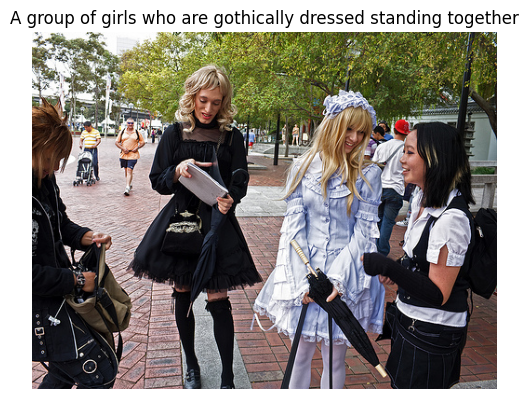


Текст запроса: A woman and a young girl riding a sled down a snowy hill while standing .
Наиболее релевантное изображение: 2141713971_e25eb12712.jpg (сходство: 0.2967)


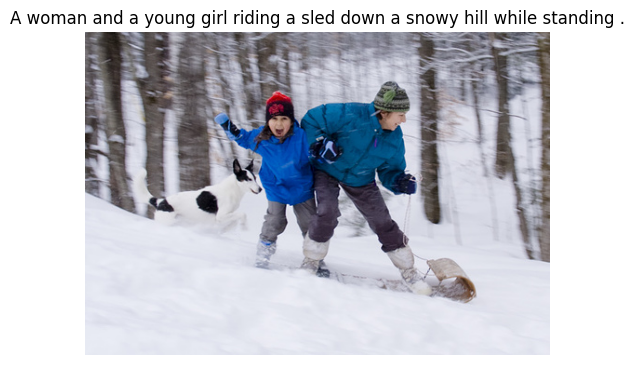


Текст запроса: The dog is running .
Наиболее релевантное изображение: 3466891862_9afde75568.jpg (сходство: 0.2842)


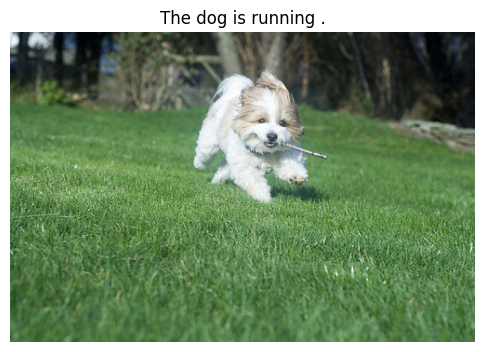


Текст запроса: The woman with a henna tattoo holds a piece of paper in her left hand .
Наиболее релевантное изображение: 2687672606_275169c35d.jpg (сходство: 0.3335)


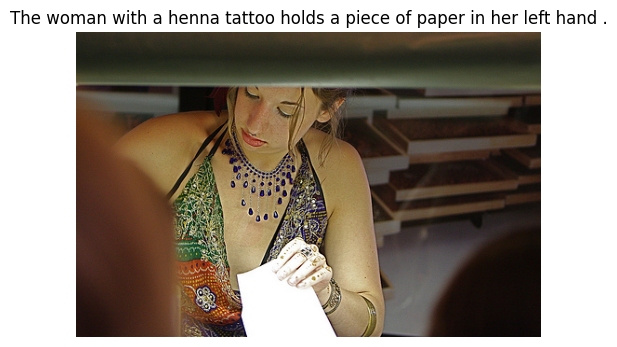


Текст запроса: A young girl in blue hat and coat is riding a tricycle .
Наиболее релевантное изображение: 2428094795_d3a8f46046.jpg (сходство: 0.3049)


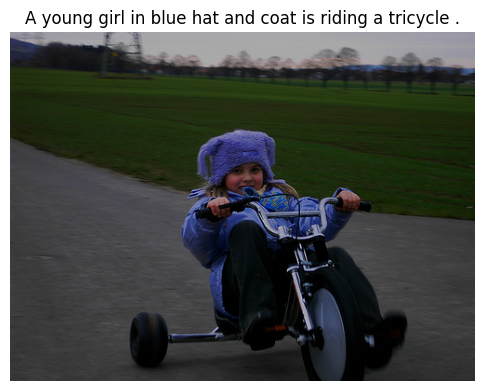


Текст запроса: Two black dogs fighting over an orange toy .
Наиболее релевантное изображение: 3154152744_4e93ec8a62.jpg (сходство: 0.3502)


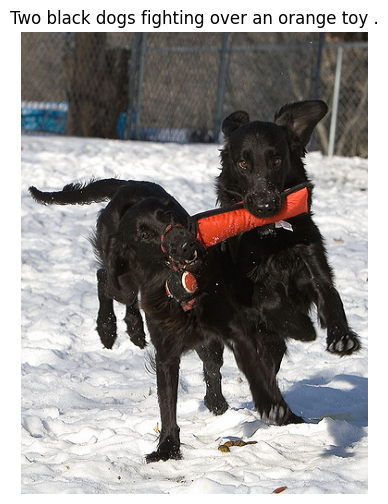


Текст запроса: A dog jumping for a tennis ball near an ocean
Наиболее релевантное изображение: 3514297698_0512623955.jpg (сходство: 0.3339)


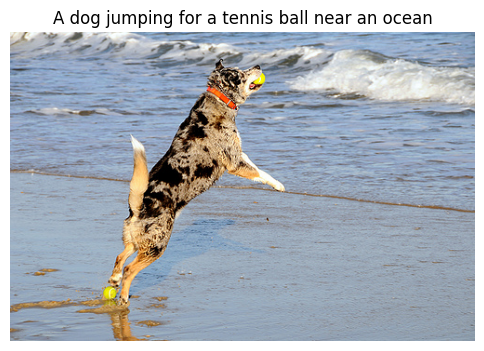


Текст запроса: A little boy is flying a kite high up in the air .
Наиболее релевантное изображение: 2505056124_1276e8dbcb.jpg (сходство: 0.3538)


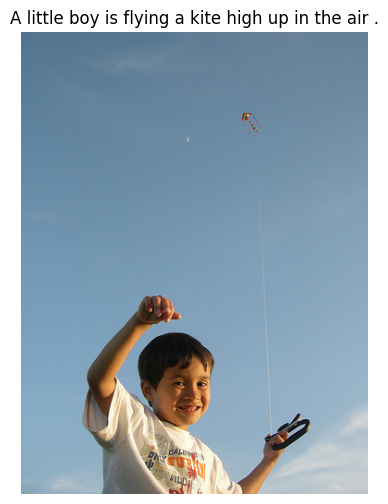


Текст запроса: A group of people in a large yard toss a disc .
Наиболее релевантное изображение: 3398788809_25c71ba018.jpg (сходство: 0.2719)


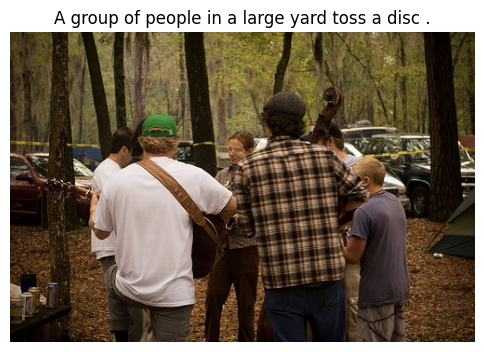


Текст запроса: A girl in a purple shirt feeding ducks
Наиболее релевантное изображение: 607339469_af851c4119.jpg (сходство: 0.3373)


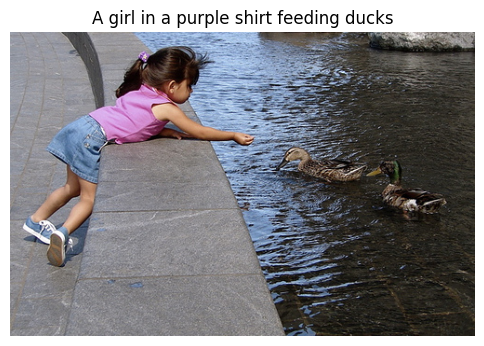

In [17]:
# =============================================================================
# 9. Тестирование модели с использованием CLIP для поиска изображений по текстовому запросу
# =============================================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util

# Путь к базовой директории (укажите ваш путь, если отличается)
base_dir = "C:/Users/Deвайс/ML/to_upload"

# Папка с тестовыми изображениями
test_imgs_dir = os.path.join(base_dir, "test_images")

# Файл для сохранения эмбеддингов тестовых изображений, вычисленных через CLIP
clip_emb_file = os.path.join(base_dir, "clip_test_embeddings.npy")

# Допустимые расширения файлов изображений
valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')
# Получаем список тестовых файлов (отсортированный)
test_files = sorted([f for f in os.listdir(test_imgs_dir) if f.lower().endswith(valid_extensions)])

# Загружаем или вычисляем эмбеддинги тестовых изображений через CLIP
clip_model = SentenceTransformer('clip-ViT-B-32')

if os.path.exists(clip_emb_file):
    print("Загружаем эмбеддинги тестовых изображений (CLIP)...")
    clip_emb = np.load(clip_emb_file)
    if len(test_files) != clip_emb.shape[0]:
        print("Количество файлов не соответствует числу эмбеддингов. Пересчитываем эмбеддинги.")
        clip_list = []
        for fname in tqdm(test_files, desc="Вычисление CLIP-эмбеддингов"):
            path = os.path.join(test_imgs_dir, fname)
            try:
                img = Image.open(path).convert("RGB")
            except Exception as e:
                print(f"Ошибка открытия изображения {fname}: {e}")
                continue
            emb = clip_model.encode(img)
            clip_list.append(emb)
        clip_emb = np.array(clip_list)
        np.save(clip_emb_file, clip_emb)
else:
    print("Вычисляем эмбеддинги тестовых изображений (CLIP)...")
    clip_list = []
    for fname in tqdm(test_files, desc="Вычисление CLIP-эмбеддингов"):
        path = os.path.join(test_imgs_dir, fname)
        try:
            img = Image.open(path).convert("RGB")
        except Exception as e:
            print(f"Ошибка открытия изображения {fname}: {e}")
            continue
        emb = clip_model.encode(img)
        clip_list.append(emb)
    clip_emb = np.array(clip_list)
    np.save(clip_emb_file, clip_emb)

# Создаем DataFrame для тестовых изображений с их CLIP-эмбеддингами
df_clip = pd.DataFrame({
    "file": test_files,
    "clip_emb": list(clip_emb)
})

# Загружаем тестовые запросы из файла test_queries.csv
# Файл должен иметь разделитель '|' и 4 колонки: индекс | query_id | query_text | image
test_queries_file = os.path.join(base_dir, "test_queries.csv")
test_queries = pd.read_csv(test_queries_file, sep='|', header=None, index_col=0,
                             names=['id', 'query_id', 'query_text', 'image'])
print("Количество тестовых запросов:", len(test_queries))

# Выбираем случайные 10 запросов
random_queries = test_queries.sample(n=10, random_state=SEED)

# Для каждого запроса вычисляем CLIP-эмбеддинг и находим наиболее похожее изображение
for query in random_queries['query_text']:
    # Вычисляем эмбеддинг запроса
    q_emb = clip_model.encode(query)
    # Получаем эмбеддинги всех тестовых изображений в виде матрицы
    img_emb_matrix = np.vstack(df_clip['clip_emb'].values)
    # Вычисляем косинусное сходство между эмбеддингом запроса и всеми эмбеддингами изображений
    sims = util.cos_sim(q_emb, img_emb_matrix)  # возвращается тензор размерности (1, N)
    sims = sims.squeeze(0).cpu().numpy()  # преобразуем в numpy-массив
    best_idx = np.argmax(sims)
    best_file = df_clip.iloc[best_idx]['file']
    best_score = sims[best_idx]
    
    # Выводим описание запроса и найденную картинку с оценкой
    print(f"\nТекст запроса: {query}")
    print(f"Наиболее релевантное изображение: {best_file} (сходство: {best_score:.4f})")
    
    # Отображаем найденное изображение
    img_path = os.path.join(test_imgs_dir, best_file)
    try:
        img = Image.open(img_path)
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis("off")
        plt.title(query, fontsize=12)
        plt.show()
    except Exception as e:
        print(f"Ошибка открытия изображения {best_file}: {e}")
